In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Risk Forecasting')

import numpy as np
import inspect
import pandas as pd
import traceback
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from contextlib import redirect_stdout
from sklearn.metrics import mean_absolute_error
from models import SVM, TFT_GRU, LGBM, Naive

plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('mathtext', fontset='stix')

# check GPU
device_name = tf.test.gpu_device_name()
if device_name:
    print(f'{device_name} found')
else:
    print("No GPU found")

feature_matrix = pd.read_pickle('/content/drive/My Drive/Risk Forecasting/features.pkl')
target_vector = (pd.read_excel('/content/drive/My Drive/Risk Forecasting/RESPONSE Main 1m.xls', skiprows=range(6))
                .rename(columns=lambda x: x.strip()).assign(**{'Effective date': lambda df: pd.to_datetime(df['Effective date'], errors='coerce')})
                .dropna(subset=['Effective date']).set_index('Effective date'))

feature_matrix.index = pd.to_datetime(feature_matrix.index, errors='coerce')
target_vector.index = pd.to_datetime(target_vector.index, errors='coerce')

# align indices
X = feature_matrix.loc[feature_matrix.index.intersection(target_vector.index)]
y = target_vector.loc[feature_matrix.index.intersection(target_vector.index)]

# # add time-related features
# X['increasing_line'] = (X.index - X.index[0]).days
# days_in_year = 252
# X['sine_wave'] = np.sin(2 * np.pi * X['increasing_line'] / days_in_year)

print(f"X shape: {X.shape}")

/device:GPU:0 found
X shape: (156, 15)


In [3]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def log_loss(actual, forecast):
    return np.mean((np.log(actual / forecast))**2)

def calculate_rmse(actual, forecast):
    return np.sqrt(np.mean((actual - forecast) ** 2))

In [4]:
def rolling_test(model_class, feature_matrix, feature_vector, chunk, predictions, sequence_length=None, model_name=""):
    '''rolling (sliding) test, that runs a model over t specified periods, models go through an independent walk-forward validation for each prediction.'''
    forecasts = np.array([])
    forecast_dates = []
    mae_scores = np.array([])
    mape_scores = np.array([])
    log_loss_scores = np.array([])
    rmse_scores = np.array([])

    t = 0

    log_file_path = f'/content/drive/My Drive/Risk Forecasting/rolling_test_{model_name}_log.txt'

    with open(log_file_path, 'w') as log_file:
        while t < predictions:
            window = (chunk - predictions) + t

            X_fit = feature_matrix.iloc[t:window]
            y_fit = feature_vector.iloc[t:window]
            X_test = feature_matrix.iloc[window:window + 1]
            y_test = feature_vector.iloc[window:window + 1]

            if y_test.empty:
                print(f"no data for {window}")
                log_file.write(f"no data for {window}\n")
                t += 1
                continue

            print(f"starting prediction for {y_test.index[0].strftime('%Y-%m-%d')}")
            log_file.write(f"starting prediction for {y_test.index[0].strftime('%Y-%m-%d')}\n")
            print(f"training window shape: X_fit={X_fit.shape}, y_fit={y_fit.shape}")
            log_file.write(f"training window shape: X_fit={X_fit.shape}, y_fit={y_fit.shape}\n")
            print(f"test window shape: X_test={X_test.shape}, y_test={y_test.shape}")
            log_file.write(f"test window shape: X_test={X_test.shape}, y_test={y_test.shape}\n")

            try:
                model_args = inspect.signature(model_class.__init__).parameters
                model = model_class(sequence_length=sequence_length) if 'sequence_length' in model_args else model_class()
                model.fit(X_fit.values, y_fit.values)
                forecast = model.predict().flatten()

                forecasts = np.append(forecasts, forecast)
                forecast_dates.append(y_test.index[0])

                mae = mean_absolute_error(y_test.values.flatten(), forecast)
                mape = calculate_mape(y_test.values.flatten(), forecast)
                log_loss_value = log_loss(np.expand_dims(y_test.values.flatten(), axis=0), np.expand_dims(forecast, axis=0))
                rmse = calculate_rmse(y_test.values.flatten(), forecast)

                mae_scores = np.append(mae_scores, mae)
                mape_scores = np.append(mape_scores, mape)
                log_loss_scores = np.append(log_loss_scores, log_loss_value)
                rmse_scores = np.append(rmse_scores, rmse)

            except Exception as e:
                print(f"An error occurred: {e}\nTraceback:\n{traceback.format_exc()}")
                log_file.write(f"An error occurred: {e}\nTraceback:\n{traceback.format_exc()}\n")
                print(f"types - X_fit: {type(X_fit)}, y_fit: {type(y_fit)}")
                log_file.write(f"types - X_fit: {type(X_fit)}, y_fit: {type(y_fit)}\n")
                print(f"dims - X_fit: {X_fit.shape}, y_fit: {y_fit.shape}")
                log_file.write(f"dims - X_fit: {X_fit.shape}, y_fit: {y_fit.shape}\n")

            t += 1

        avg_mae = np.mean(mae_scores)
        avg_mape = np.mean(mape_scores)
        avg_log_loss = np.mean(log_loss_scores)
        avg_rmse = np.mean(rmse_scores)

        print(f"avg. MAE: {avg_mae}")
        log_file.write(f"avg. MAE: {avg_mae}\n")
        print(f"avg. MAPE: {avg_mape}")
        log_file.write(f"avg. MAPE: {avg_mape}\n")
        print(f"avg. Log Loss: {avg_log_loss}")
        log_file.write(f"avg. Log Loss: {avg_log_loss}\n")
        print(f"avg. RMSE: {avg_rmse}")
        log_file.write(f"avg. RMSE: {avg_rmse}\n")

    if forecast_dates:
        plt.figure(figsize=(12, 6))
        forecast_dates = pd.DatetimeIndex(forecast_dates)
        actuals = feature_vector.loc[forecast_dates]
        estimates = forecasts[:len(forecast_dates)]
        plt.plot(forecast_dates, actuals, 'o', color='grey', label='Actual')
        plt.plot(forecast_dates, estimates, 'x', color='black', label='Estimate')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Estimate vs Actual - {model_name}')
        plt.legend()
        plt.savefig(f'/content/drive/My Drive/Risk Forecasting/{model_name}_estimates_vs_actuals.png')
        plt.show()

        residuals = actuals.values.flatten() - estimates
        plt.figure(figsize=(12, 6))
        plt.plot(forecast_dates, residuals, 'x', color='black')
        plt.axhline(y=0, color='grey', linestyle='--')
        for date, residual in zip(forecast_dates, residuals):
            plt.vlines(x=date, ymin=0, ymax=residual, color='black', linestyle='--', alpha=0.5)
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot - {model_name}')
        plt.savefig(f'/content/drive/My Drive/Risk Forecasting/{model_name}_residual_plot.png')
        plt.show()
    else:
        print("forecasts were not made: unable to plot results.")

    return {'MAE': avg_mae, 'MAPE': avg_mape, 'Log Loss': avg_log_loss, 'RMSE': avg_rmse}

In [5]:
window = 50 # number of observations passed to model
predictions = 10 # subset at end of sliced observations dedicated to estimates (model will be fit on observations - predictions)
sequence_length = 5 # length of sequences (set to 5 for trading week)

In [6]:
model_metrics = {}

starting prediction for 2023-02-10
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prediction for 2023-02-13
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prediction for 2023-02-14
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prediction for 2023-02-15
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prediction for 2023-02-16
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prediction for 2023-02-17
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prediction for 2023-02-20
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
starting prediction for 2023-02-21
traini

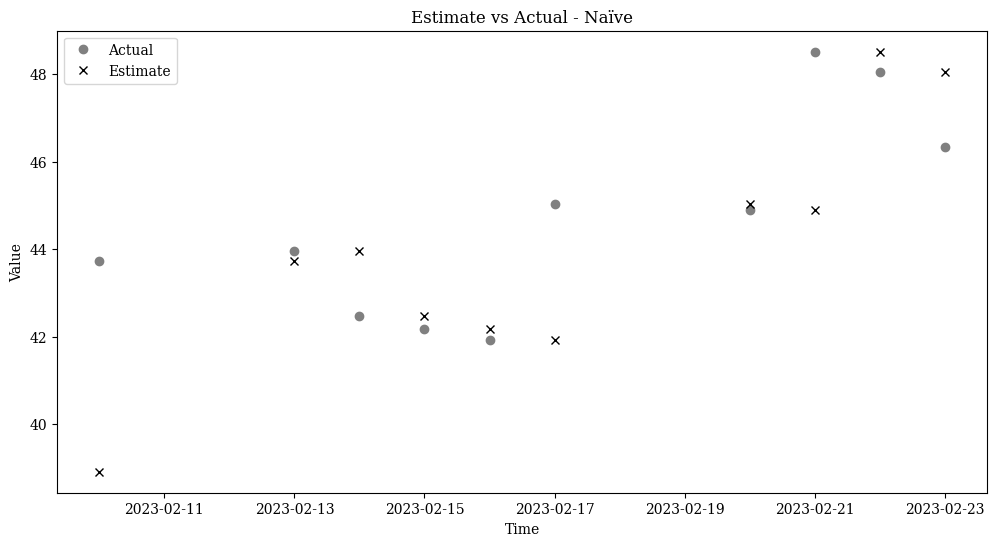

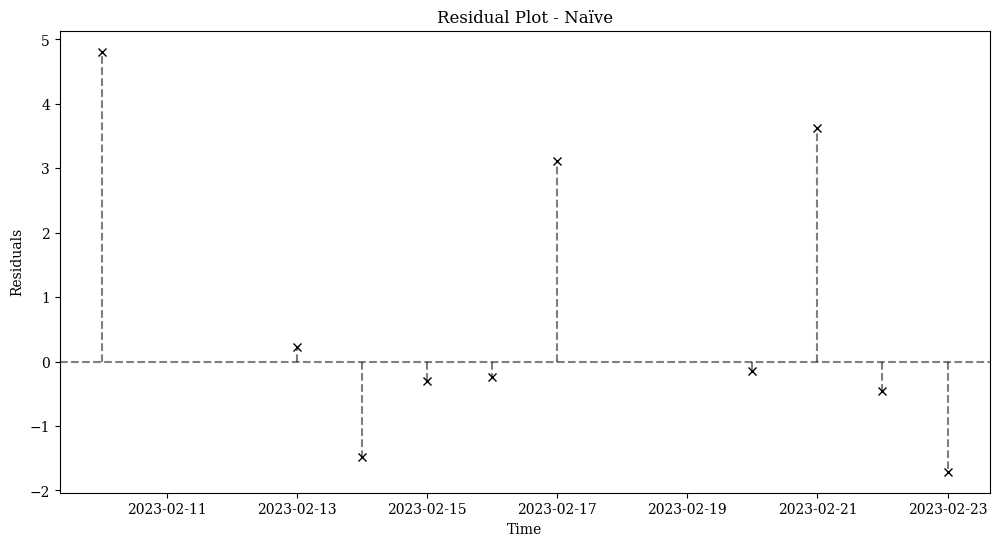

In [7]:
model_metrics['Naïve Forecast'] = rolling_test(Naive, X, y, chunk=(window + predictions), predictions=predictions, model_name='Naïve')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
Step 4 Validation MSE: 0.5908583280578203
Step 5: Training on 9 samples, Validating on 1 samples
Epoch 1/20
1/1 [==============================] - 0s 112ms/step - loss: 0.2140 - val_loss: 0.3227 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 0s 56ms/step - loss: 0.1922 - val_loss: 0.3260 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 0s 44ms/step - loss: 0.4648 - val_loss: 0.2323 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 0s 48ms/step - loss: 0.9541 - val_loss: 0.2045 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - 0s 47ms/step - loss: 0.2613 - val_loss: 0.1802 - lr: 0.0010
Epoch 6/20
1/1 [==============================] - 0s 46ms/step - loss: 0.1931 - val_loss: 0.1041 - lr: 0.0010
Epoch 7/20
1/1 [==============================] - 0s 23ms/step
Step 5 Validation MSE: 0.3259907118391465
Step 6: Training on 10 samples, Va

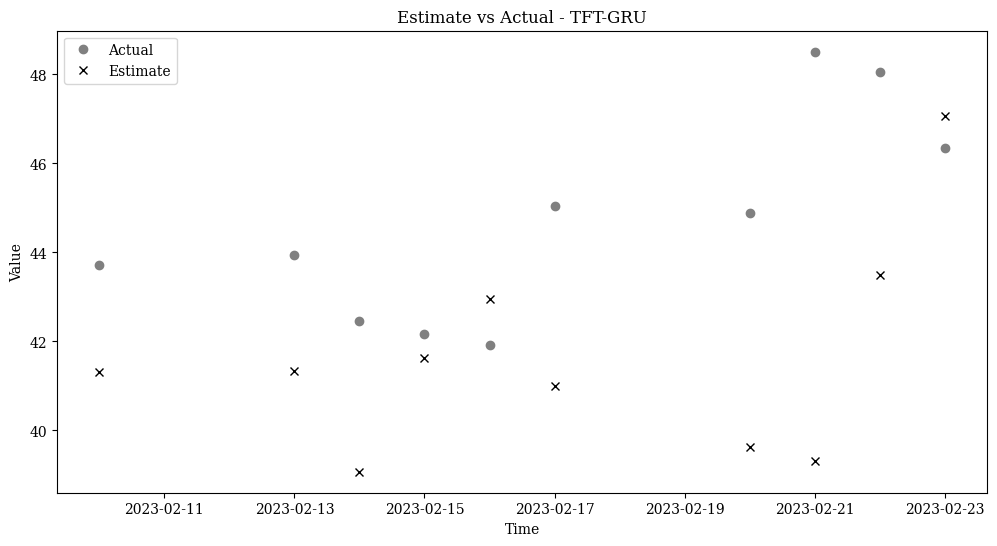

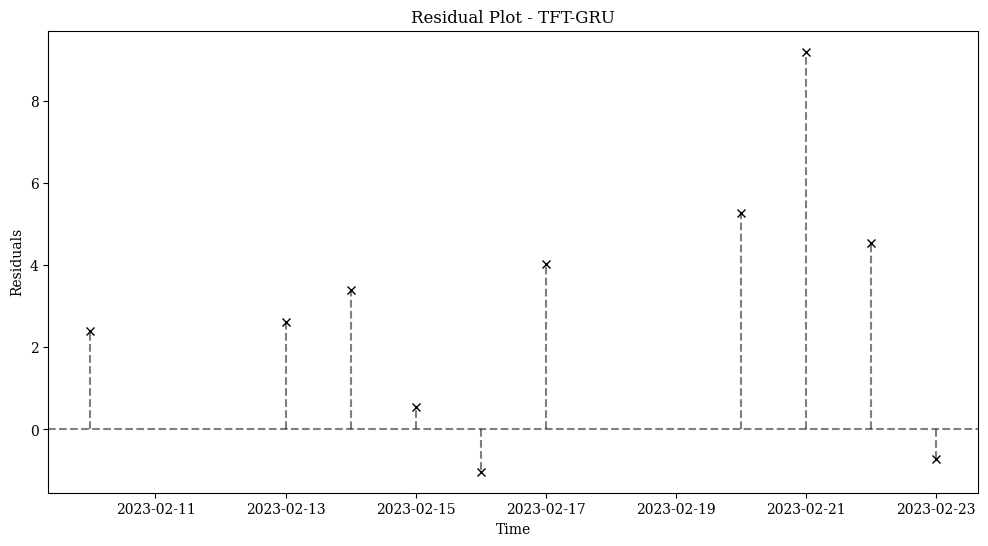

In [8]:
with tf.device('/device:GPU:0'):
    model_metrics['TFT-GRU'] = rolling_test(TFT_GRU, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name='TFT-GRU')

Streaming output truncated to the last 5000 lines.
[40]	valid_0's rmse: 0.0558919
[50]	valid_0's rmse: 0.0346933
[60]	valid_0's rmse: 0.0247689
[70]	valid_0's rmse: 0.0163023
[80]	valid_0's rmse: 0.00937933
[90]	valid_0's rmse: 0.0076254
[100]	valid_0's rmse: 0.00773952
[110]	valid_0's rmse: 0.00773952
Early stopping, best iteration is:
[94]	valid_0's rmse: 0.00740255
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 0.178588
[20]	valid_0's rmse: 0.125999
[30]	valid_0's rmse: 0.0861043
[40]	valid_0's rmse: 0.0587501
[50]	valid_0's rmse: 0.039975
[60]	valid_0's rmse: 0.029596
[70]	valid_0's rmse: 0.0269145
[80]	valid_0's rmse: 0.0243196
[90]	valid_0's rmse: 0.0228443
[100]	valid_0's rmse: 0.0219747
[110]	valid_0's rmse: 0.0219747
Early stopping, best iteration is:
[95]	valid_0's rmse: 0.0219747
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 0.218494
[20]	valid_0's rmse: 0.152705
[30]	valid_0's rmse: 0.105112
[40]	valid_0

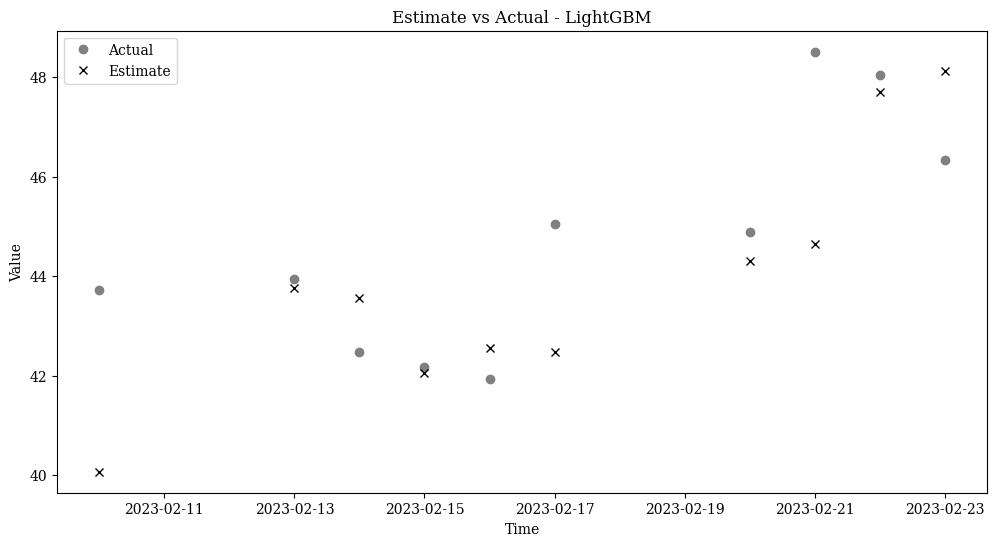

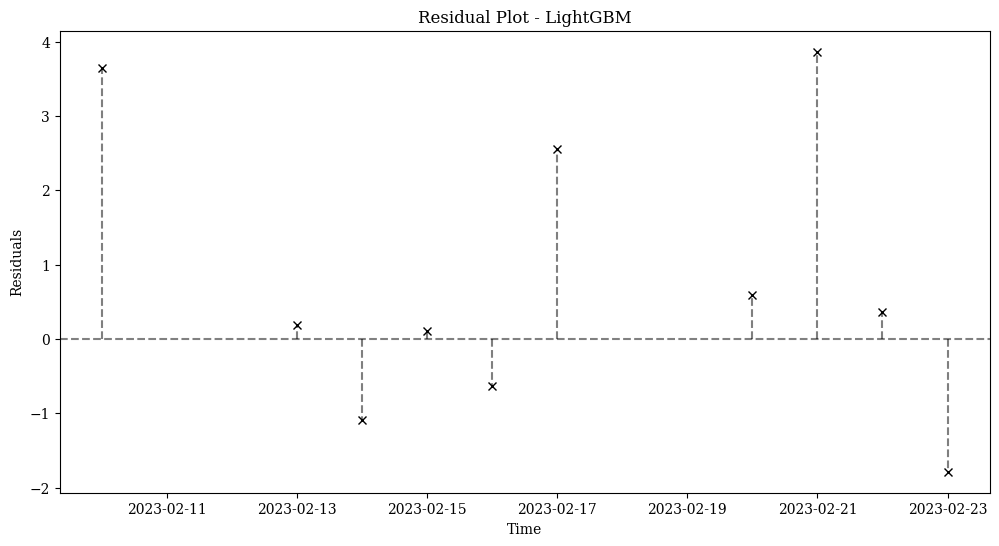

In [9]:
model_metrics['LightGBM'] = rolling_test(LGBM, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name='LightGBM')

starting prediction for 2023-02-10
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
X dims pre-sequencing: (50, 15)
y dims pre-sequencing: (50, 1)
stacked shape: (50, 16)
Best params found: {'kernel': 'sigmoid', 'C': 15, 'epsilon': 0.05, 'gamma': 0.05} with score 2373.9275557596084
starting prediction for 2023-02-13
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
X dims pre-sequencing: (50, 15)
y dims pre-sequencing: (50, 1)
stacked shape: (50, 16)
Best params found: {'kernel': 'sigmoid', 'C': 15, 'epsilon': 0.01, 'gamma': 0.05} with score 2344.982137778206
starting prediction for 2023-02-14
training window shape: X_fit=(50, 15), y_fit=(50, 1)
test window shape: X_test=(1, 15), y_test=(1, 1)
X dims pre-sequencing: (50, 15)
y dims pre-sequencing: (50, 1)
stacked shape: (50, 16)
Best params found: {'kernel': 'sigmoid', 'C': 15, 'epsilon': 0.01, 'gamma': 0.05} with score 2335.2568957

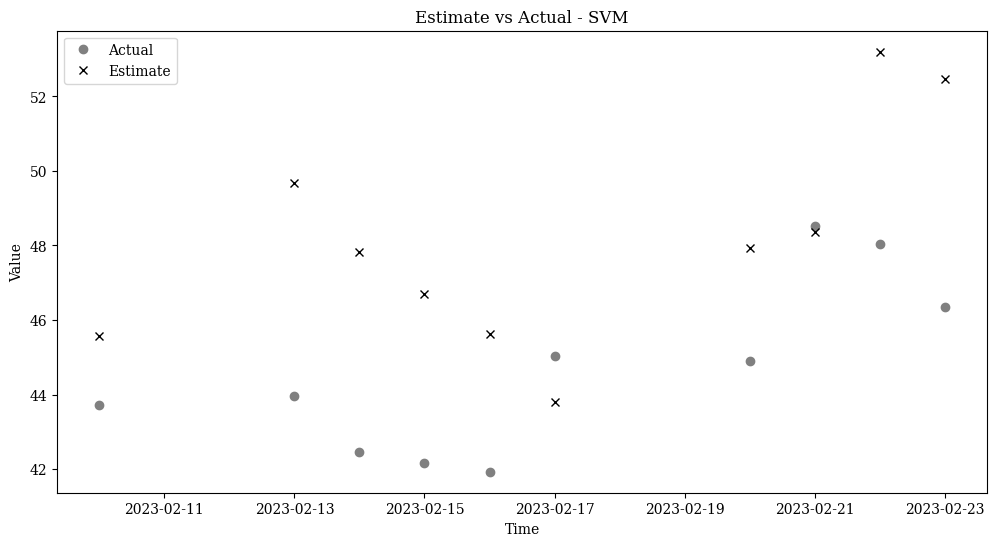

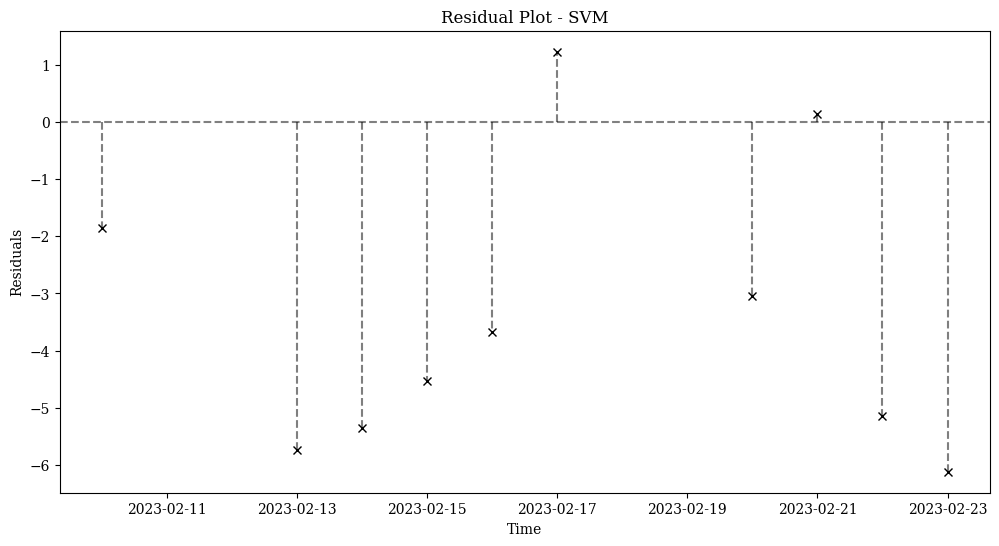

In [10]:
model_metrics['SVM'] = rolling_test(SVM, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name='SVM')

In [11]:
metrics_df = pd.DataFrame(model_metrics)

metrics_df

,Naïve Forecast,TFT-GRU,LightGBM,SVM
MAE,1.611000,3.377261,1.481801,3.684653
MAPE,3.564271,7.389591,3.265206,8.316080
Log Loss,0.002742,0.009346,0.002045,0.007921
RMSE,1.611000,3.377261,1.481801,3.684653


In [12]:
latex_code = metrics_df.to_latex(index=False)
with open('/content/drive/My Drive/Risk Forecasting/model_metrics_table.tex', 'w') as f:
    f.write(latex_code)